<font color="green">**LSTM model for predictions on stock data only**</font>

**Import libraries**

In [ ]:
#Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

**Get stock data and visualize**

In [ ]:
#Get the stock quote 
df = web.DataReader('AMD', data_source='yahoo', start='2016-07-22', end='2020-05-26') 

#To get the stock quote for other companies like Apple, Disney, Tesla=> Uncomment the required line below
#df = web.DataReader('AAPL', data_source='yahoo', start='2016-07-22', end='2020-05-26')
#df = web.DataReader('DIS', data_source='yahoo', start='2016-07-22', end='2020-05-26')
#df = web.DataReader('TSLA', data_source='yahoo', start='2016-07-22', end='2020-05-26')

#Show the data 
df.head(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-07-22,5.97,5.45,5.73,5.84,101838300,5.84
2016-07-25,6.95,5.92,5.93,6.70,118328600,6.70
2016-07-26,7.16,6.71,6.76,6.98,81230600,6.98
2016-07-27,6.98,6.68,6.93,6.85,38567300,6.85
2016-07-28,6.98,6.74,6.79,6.82,27515600,6.82


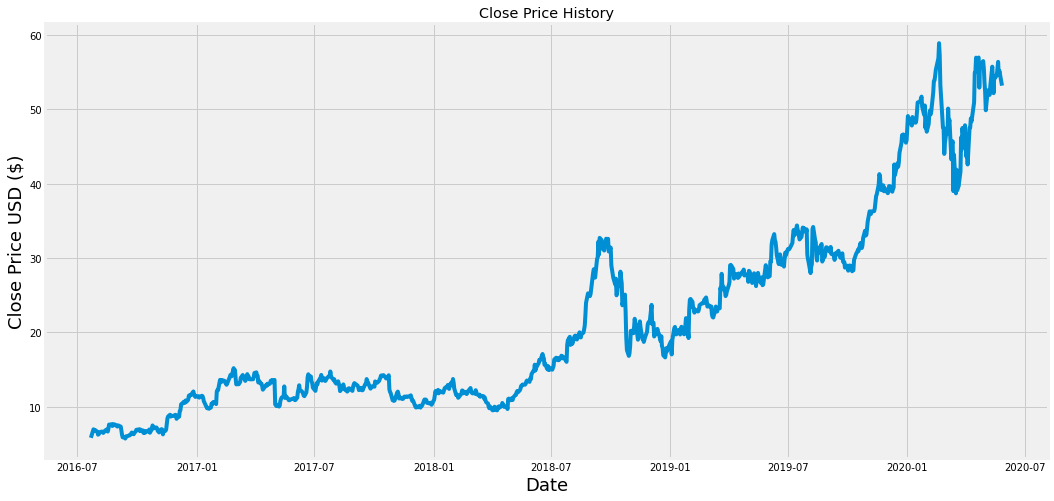

In [ ]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

**Preprocess data and split into train-test dataset**

In [ ]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8)

In [ ]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [ ]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])

In [ ]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
  x_test.append(test_data[i-60:i,0])

In [ ]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)

**Build model and train on training data**

In [ ]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [ ]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
#model.compile(optimizer='adam',loss='mean_absolute_error')

In [ ]:
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [ ]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

714/714 [==============================] - 15s 21ms/step - loss: 0.0019


In [ ]:
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

**Predict on testing data and visualize predictions**

In [ ]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling

In [ ]:
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

3.640197749552294

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


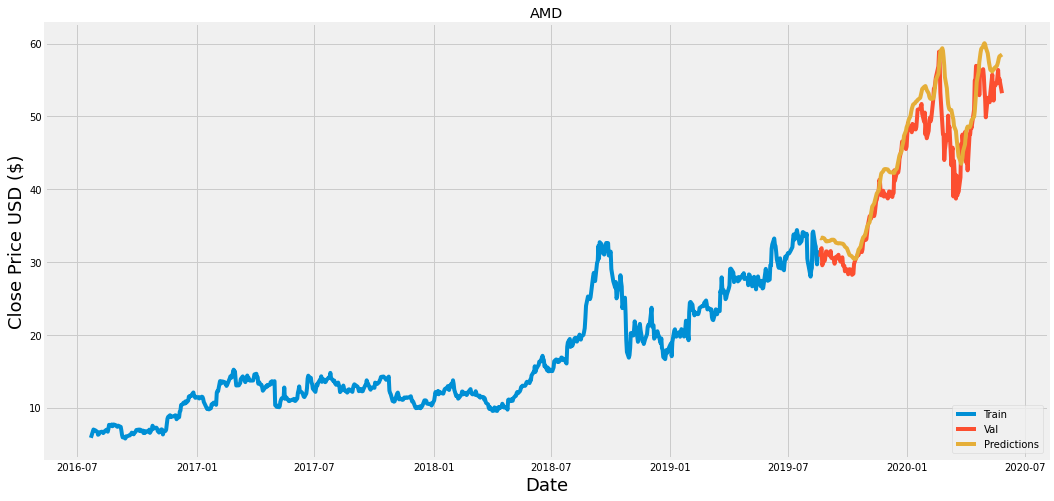

In [ ]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('AMD')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

<font color="green">**LSTM model for stock prediction using stock data and news vectors data**</font>

**Get news vectors data and preprocess**

In [ ]:
#Read news vectors data from provided data file
newsVectors=pd.read_csv('vectorAMD.csv')
newsVectors.head(3)

,date,news,vectors
0,2020-05-26,BLICKNovartisAugenarznei Beovu kommt künftig a...,[ 5.07812500e-02 -3.95329781e-02 1.02132158e-...
1,2020-05-19,Brazil stock exchange B3 operation despite hol...,[-0.00317383 0.05178223 -0.00095215 -0.041371...
2,2020-05-11,Kodiak Sciences Announces Q1 2020 Financial Re...,[-1.43147781e-01 -8.14208984e-02 -5.43619804e-...


In [ ]:
#Data preprocessing steps
newsVectors=newsVectors.drop('news',axis=1)
newsVectors['date'] = pd.to_datetime(newsVectors['date'])
newsVectors['date'] = newsVectors['date'].dt.date
grouped=newsVectors.groupby('date').sum()
grouped=grouped.reset_index()
grouped.head(3)
#newsVectors.head(3)
#grouped=newsVectors.groupby('date').mean()

,date,vectors
0,2016-07-22,[-0.00675456 0.04950969 -0.00374349 0.153157...
1,2016-08-03,[ 1.18029788e-01 2.70996094e-02 -1.37069700e-...
2,2016-08-25,[-3.05175781e-04 4.10766602e-02 6.50721937e-...


In [ ]:
#Populate missing values using imputation method
r = pd.date_range(start=grouped.date.min(), end=grouped.date.max())
grouped=grouped.set_index('date').reindex(r).rename_axis('date').reset_index()
grouped=grouped.ffill(axis=0)
grouped.head(3)

,date,vectors
0,2016-07-22,[-0.00675456 0.04950969 -0.00374349 0.153157...
1,2016-07-23,[-0.00675456 0.04950969 -0.00374349 0.153157...
2,2016-07-24,[-0.00675456 0.04950969 -0.00374349 0.153157...


In [ ]:
df1=df.reset_index()
df1.head(3)

,Date,High,Low,Open,Close,Volume,Adj Close
0,2016-07-22,5.97,5.45,5.73,5.84,101838300,5.84
1,2016-07-25,6.95,5.92,5.93,6.70,118328600,6.70
2,2016-07-26,7.16,6.71,6.76,6.98,81230600,6.98


In [ ]:
grouped.dtypes

date       datetime64[ns]
vectors            object
dtype: object

In [ ]:
newsScores['date'] = pd.to_datetime(newsScores['date'])

**Combine news data with stock data and visualize**

In [ ]:
#Merge stock data with news vectors data
merged_data = pd.merge(left=df1, right=grouped, left_on='Date', right_on='date') #merge datasets
merged_data.drop(['date'], axis=1,inplace=True) #remove redundant column
merged_data.head(3)

,Date,High,Low,Open,Close,Volume,Adj Close,vectors
0,2016-07-22,5.97,5.45,5.73,5.84,101838300,5.84,[-0.00675456 0.04950969 -0.00374349 0.153157...
1,2016-07-25,6.95,5.92,5.93,6.70,118328600,6.70,[-0.00675456 0.04950969 -0.00374349 0.153157...
2,2016-07-26,7.16,6.71,6.76,6.98,81230600,6.98,[-0.00675456 0.04950969 -0.00374349 0.153157...


In [ ]:
merged_data.set_index('Date')
merged_data.head(3)

,Date,High,Low,Open,Close,Volume,Adj Close,vectors
0,2016-07-22,5.97,5.45,5.73,5.84,101838300,5.84,[-0.00675456 0.04950969 -0.00374349 0.153157...
1,2016-07-25,6.95,5.92,5.93,6.70,118328600,6.70,[-0.00675456 0.04950969 -0.00374349 0.153157...
2,2016-07-26,7.16,6.71,6.76,6.98,81230600,6.98,[-0.00675456 0.04950969 -0.00374349 0.153157...


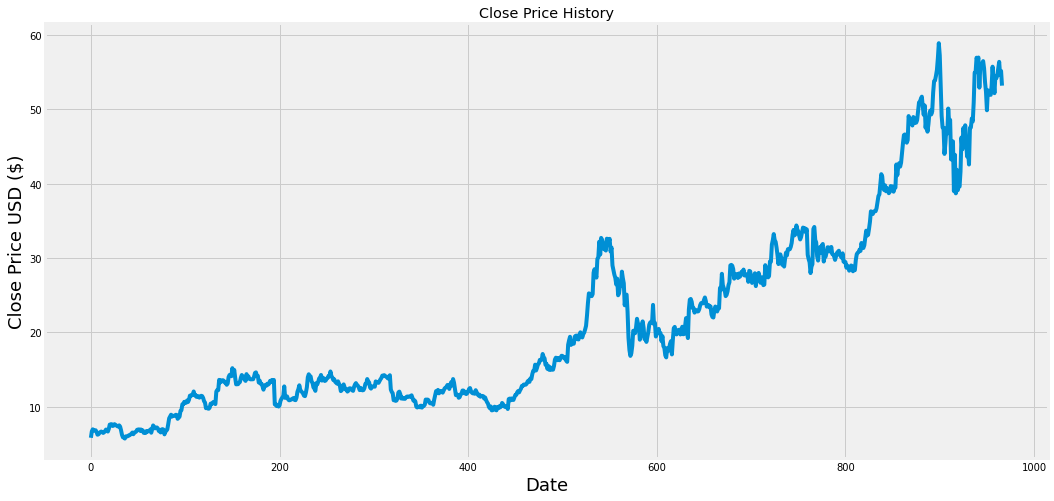

In [ ]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(merged_data['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

**Preprocess merged data and split into train-test dataset**

In [ ]:
#Create a new dataframe with 'Close' column
data = merged_data.filter(['Close'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8)

In [ ]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [ ]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])

In [ ]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
  x_test.append(test_data[i-60:i,0])

In [ ]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)

**Build model and train on training data**

In [ ]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [ ]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [ ]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

714/714 [==============================] - 17s 23ms/step - loss: 0.0015


In [ ]:
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

**Predict on testing data and visualize predictions**

In [ ]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling

In [ ]:
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

2.483905463752487

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


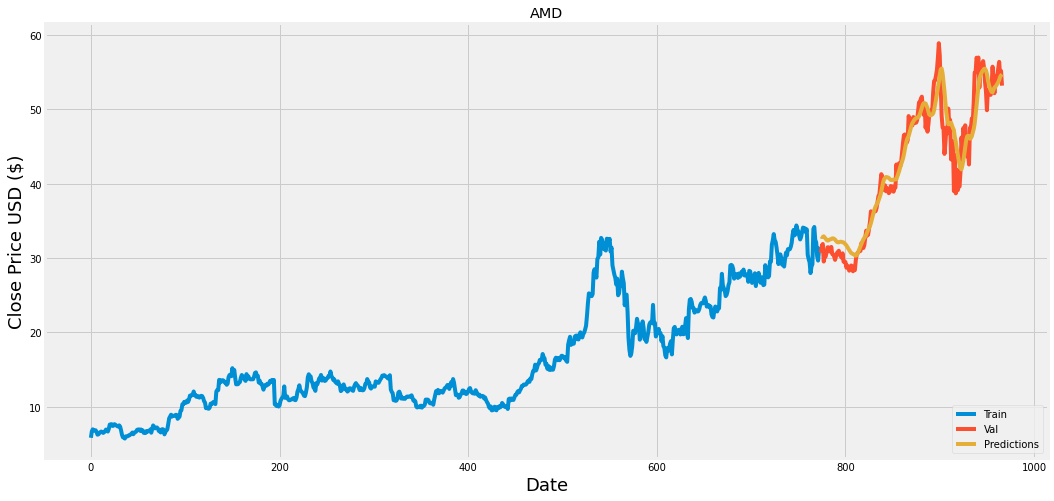

In [ ]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('AMD')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()